In [37]:
import os 
from collections import namedtuple as tup
import argparse
import numpy as np
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from sched_solver import Solver
import sched_heuristic as heu
import pickle
from scipy.stats import kendalltau as tau, spearmanr as rho
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

In [2]:
num_procs = 8 
num_tasks = 32
util = "6.20"

In [3]:
model = torch.load("p4-t20")

In [4]:
with open("te/%d-%d/%s" % (num_procs, num_tasks, util), 'rb') as f:
        test_dataset = pickle.load(f)

In [66]:
loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [194]:
r = []
_in = []
for i, batch in loader:
    inputs = model.input_transform(batch)
    bb = batch.squeeze(0)
    _in.append(bb)
    inputs.permute(0, 2, 1)
    inputs.squeeze(0)
    inputs = inputs.reshape(inputs.shape[0]* inputs.shape[1], inputs.shape[2])
    r.append(inputs)
    if len(r) >= 30000:
        break

In [195]:
_in[0].shape

torch.Size([32, 3])

In [196]:
x = torch.cat(r)
_in = torch.cat(_in)[:30000]
tmp = x[:30000].numpy()
tmp.shape

(30000, 10)

In [199]:
ret = TSNE(n_components=2, perplexity=20,  verbose=2, metric='euclidean', n_jobs=-1).fit_transform(tmp)

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 30000 samples in 0.063s...
[t-SNE] Computed neighbors for 30000 samples in 0.497s...
[t-SNE] Computed conditional probabilities for sample 1000 / 30000
[t-SNE] Computed conditional probabilities for sample 2000 / 30000
[t-SNE] Computed conditional probabilities for sample 3000 / 30000
[t-SNE] Computed conditional probabilities for sample 4000 / 30000
[t-SNE] Computed conditional probabilities for sample 5000 / 30000
[t-SNE] Computed conditional probabilities for sample 6000 / 30000
[t-SNE] Computed conditional probabilities for sample 7000 / 30000
[t-SNE] Computed conditional probabilities for sample 8000 / 30000
[t-SNE] Computed conditional probabilities for sample 9000 / 30000
[t-SNE] Computed conditional probabilities for sample 10000 / 30000
[t-SNE] Computed conditional probabilities for sample 11000 / 30000
[t-SNE] Computed conditional probabilities for sample 12000 / 30000
[t-SNE] Computed conditional probabilities for sam

In [201]:
ncs=6
km = KMeans(n_clusters=ncs, n_jobs=-1)
km.fit(tmp)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [202]:
r1 = km.predict(tmp)

In [203]:
_in.shape

torch.Size([30000, 3])

In [204]:
mx = []
for i in range(ncs):
    mx.append(_in[r1 == i].numpy())

In [205]:
i = 0
for i in range(ncs):
    print(np.log(mx[i][:, 0]).mean(axis=0), np.log(mx[i][:, 1]).mean(axis=0))

6.272871429080249 4.225688301624742
8.428795915932207 6.348401736688939
3.121168641519577 0.8360202688875528
7.562943454091075 5.544540538544616
4.762446853688706 2.5091171625749986
8.987421958102301 6.655722932055317


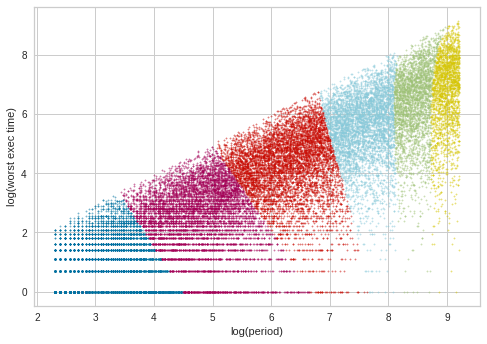

In [208]:
colors = ['r','g','b','c','m','y']

for i in range(ncs):
    _mx = np.log(mx[i])
    plt.scatter(_mx[:, 0], _mx[:, 1], color=colors[i], s=2, alpha=0.5)
    plt.xlabel("log(period)")
    plt.ylabel("log(worst exec time)")

plt.show()

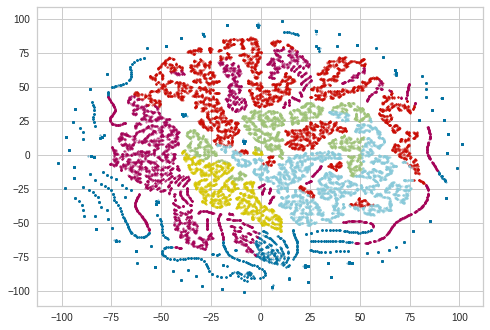

In [207]:
ret
for i in range(ncs):
    _mx = ret[r1 == i]
    plt.scatter(_mx[:, 0], _mx[:, 1], color=colors[i], s=3, alpha=0.5)